Analysis completed. All figures and statistics have been saved.


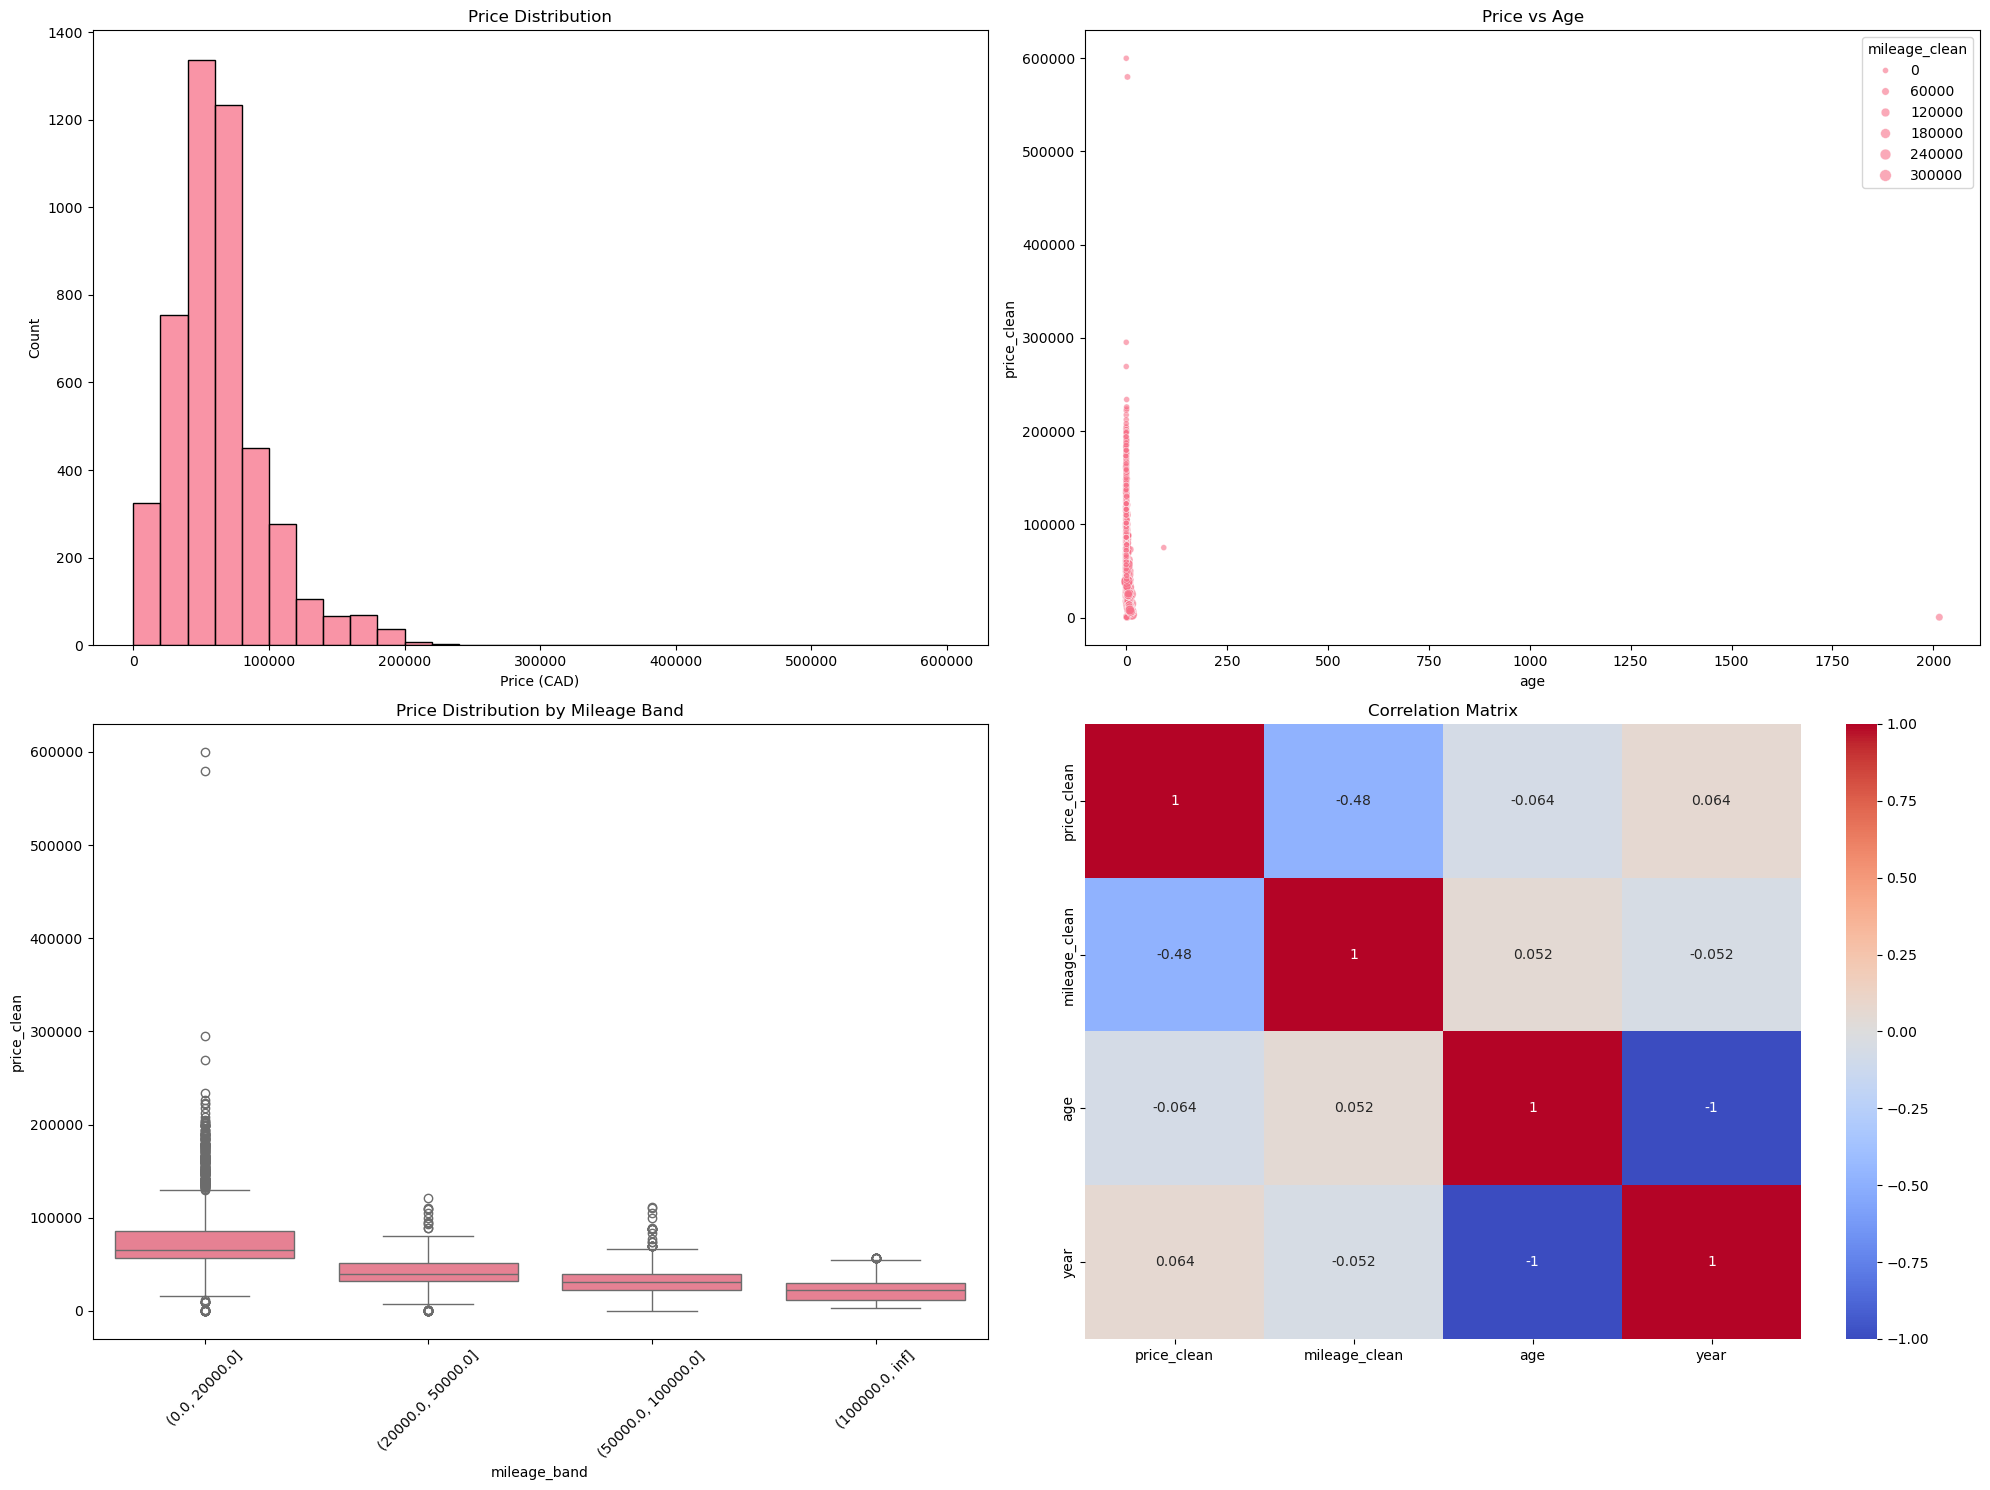

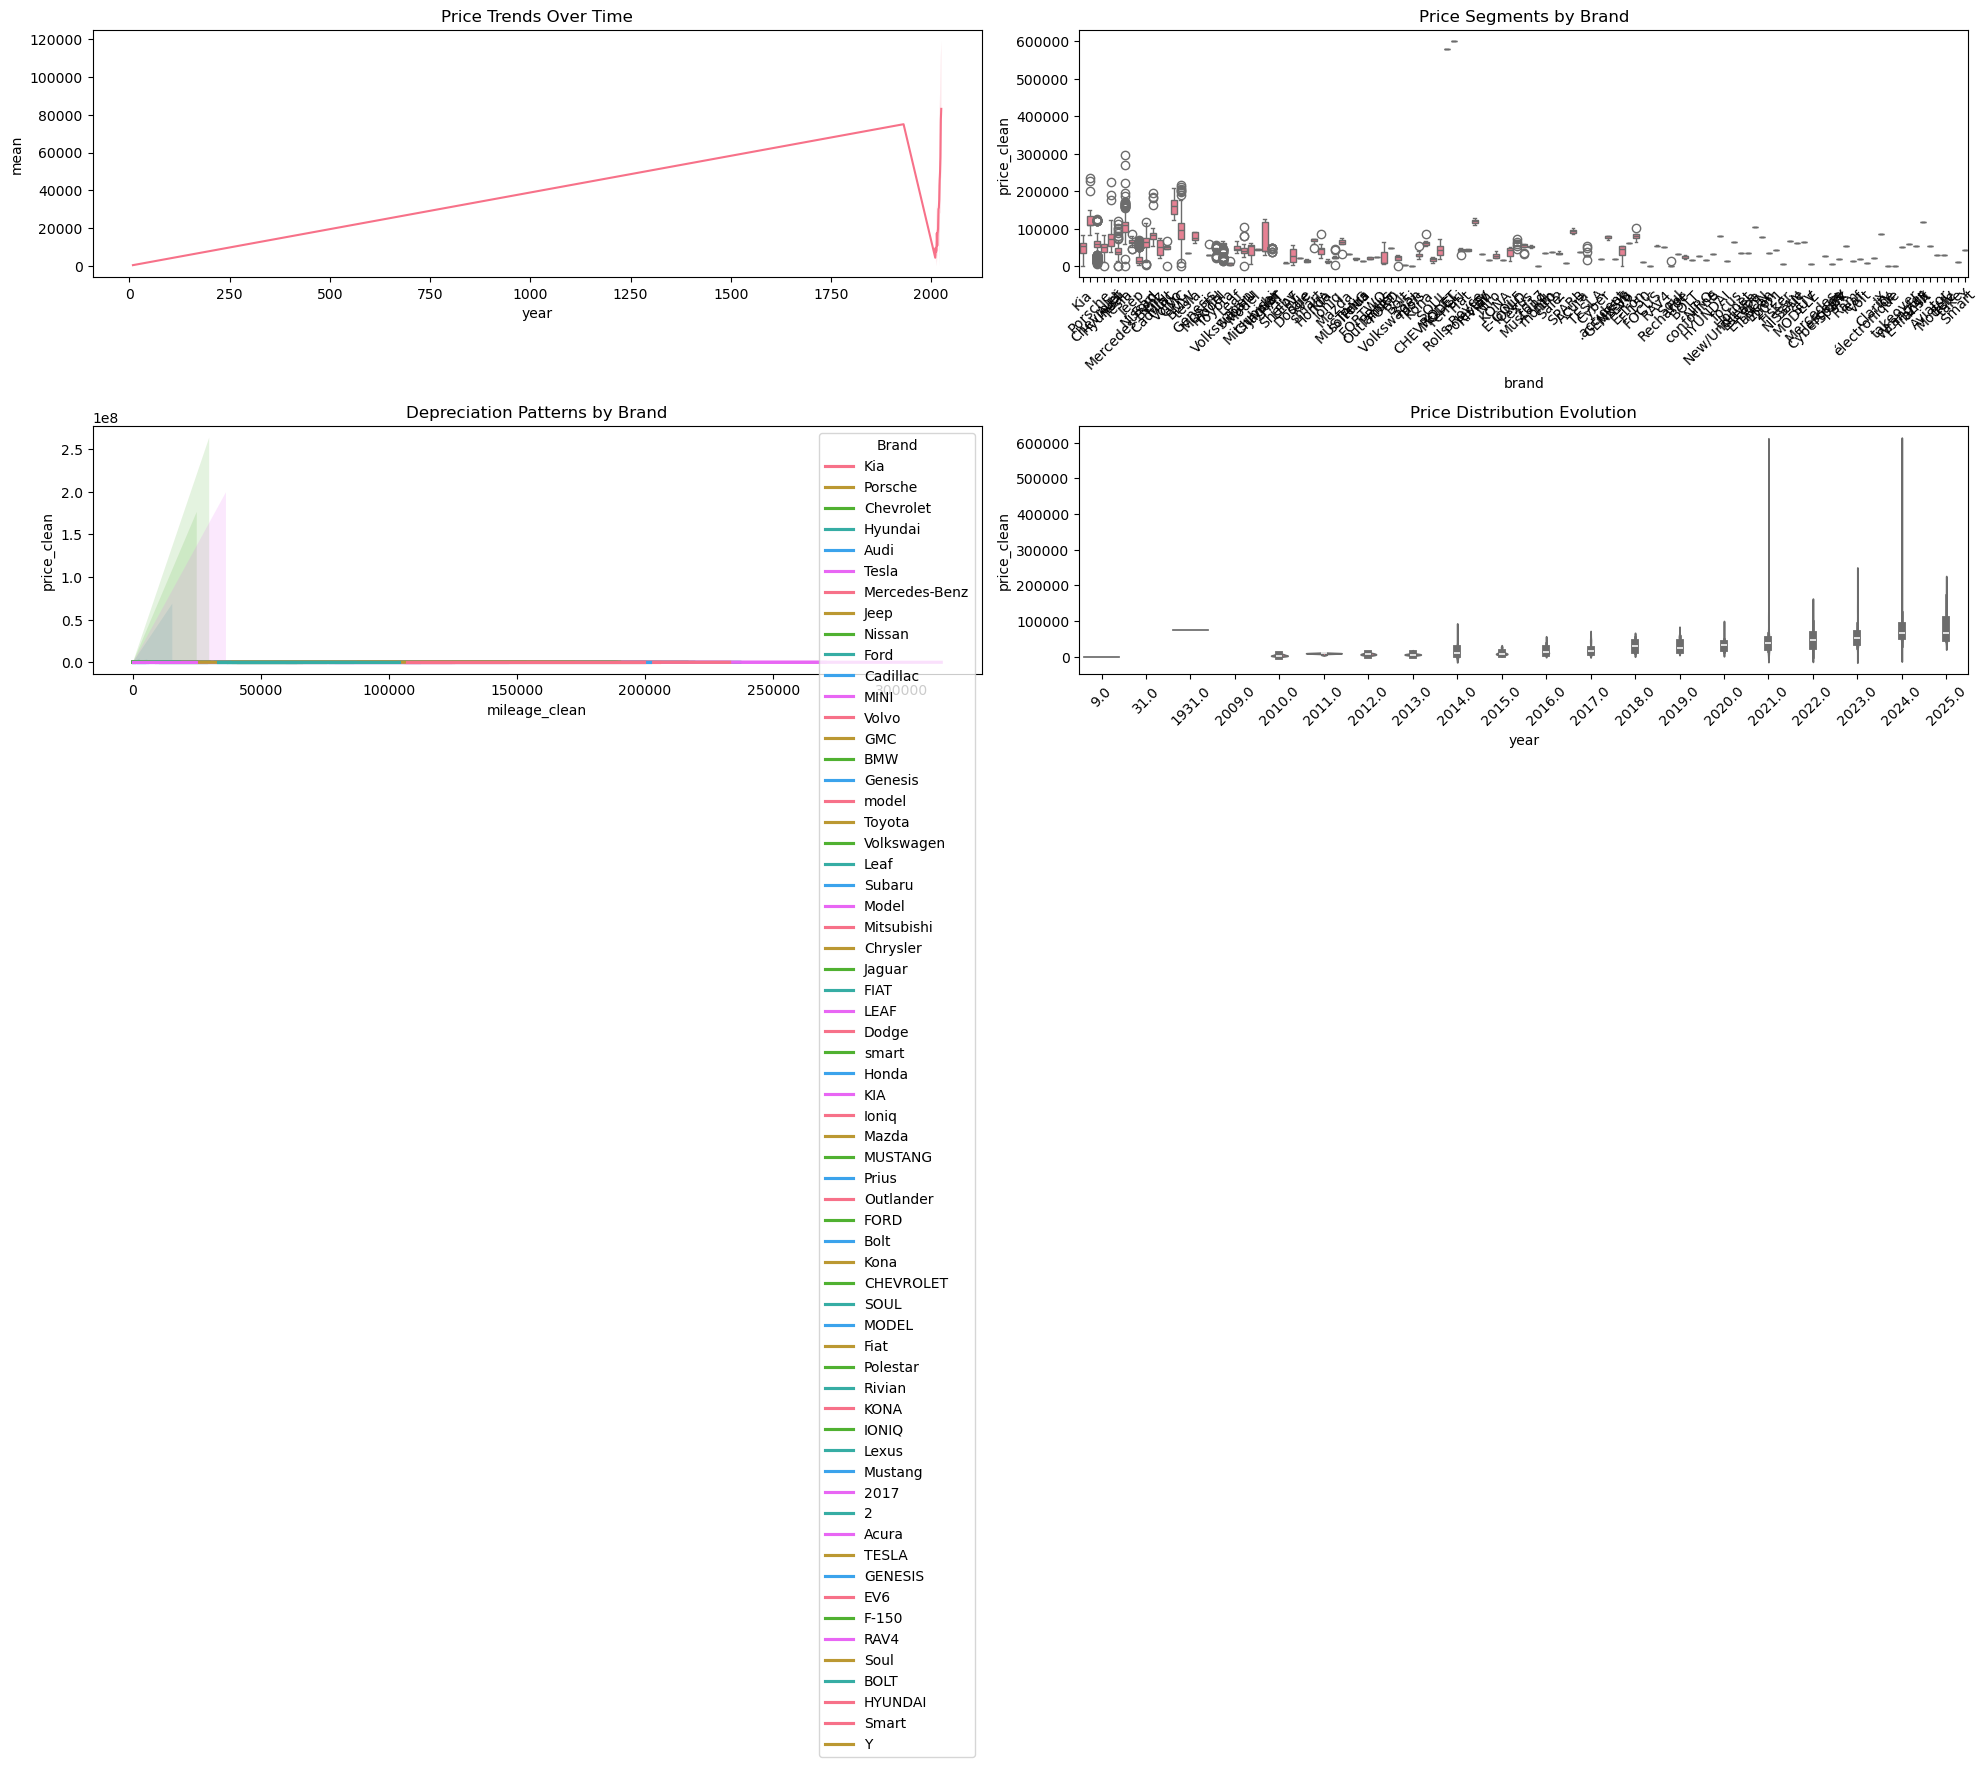

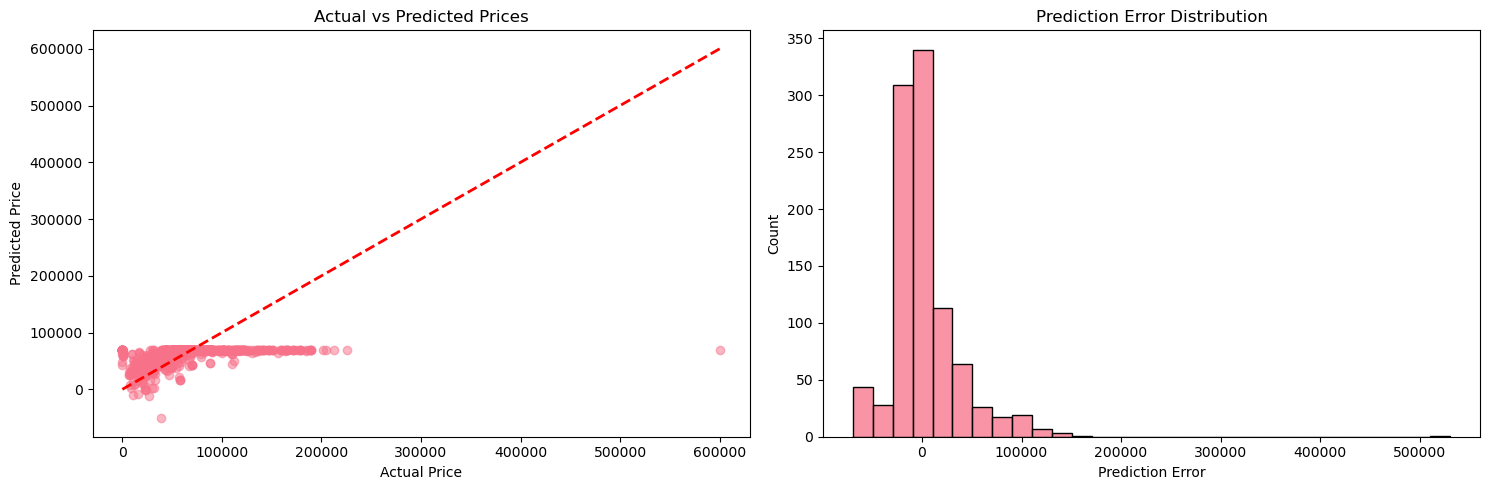

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class EVMarketAnalyzer:
    """
    A comprehensive analyzer for EV market data following the data analysis framework
    from Week 9 guidelines
    """

    def __init__(self):
        """Initialize the analyzer with data loading and preprocessing"""
        # Load datasets
        self.kijiji_data = pd.read_csv('cleaned_kijiji_electric_car_listings.csv')
        self.plugndrive_vehicles = pd.read_csv('cleaned_plugndrive_vehicles_data.csv')
        self.charger_data = pd.read_csv('cleaned_plugndrive_chargers_data.csv')

        # Set visualization style
        plt.style.use('default')
        sns.set_palette("husl")

    def preprocess_data(self):
        """
        Step 1: Data Preprocessing
        - Handle missing values
        - Convert data types
        - Create derived features
        - Normalize numerical values
        """
        # Convert datatypes and handle missing values
        self.kijiji_data['year'] = pd.to_numeric(self.kijiji_data['year'], errors='coerce')
        self.kijiji_data['price_clean'] = pd.to_numeric(self.kijiji_data['price_clean'], errors='coerce')
        self.kijiji_data['mileage_clean'] = pd.to_numeric(self.kijiji_data['mileage_clean'], errors='coerce')

        # Create derived features
        self.kijiji_data['age'] = 2024 - self.kijiji_data['year']
        self.kijiji_data['price_per_km'] = self.kijiji_data['price_clean'] / (self.kijiji_data['mileage_clean'] + 1)

        # Create mileage bands for analysis
        mileage_bands = [0, 20000, 50000, 100000, float('inf')]
        self.kijiji_data['mileage_band'] = pd.cut(self.kijiji_data['mileage_clean'], bins=mileage_bands)

        # Normalize numerical values for modeling
        scaler = StandardScaler()
        numeric_cols = ['price_clean', 'mileage_clean', 'age']
        self.kijiji_data_normalized = self.kijiji_data.copy()
        self.kijiji_data_normalized[numeric_cols] = scaler.fit_transform(
            self.kijiji_data_normalized[numeric_cols].fillna(0)
        )

        return self.kijiji_data

    def exploratory_analysis(self):
        """
        Step 2: Exploratory Data Analysis
        - Statistical summaries
        - Distribution analysis
        - Correlation analysis
        """
        fig = plt.figure(figsize=(20, 15))

        # Price Distribution
        ax1 = plt.subplot(2, 2, 1)
        sns.histplot(data=self.kijiji_data, x='price_clean', bins=30, ax=ax1)
        ax1.set_title('Price Distribution')
        ax1.set_xlabel('Price (CAD)')

        # Price vs Age Relationship
        ax2 = plt.subplot(2, 2, 2)
        sns.scatterplot(data=self.kijiji_data,
                        x='age',
                        y='price_clean',
                        size='mileage_clean',
                        alpha=0.6,
                        ax=ax2)
        ax2.set_title('Price vs Age')

        # Price by Mileage Band
        ax3 = plt.subplot(2, 2, 3)
        sns.boxplot(data=self.kijiji_data,
                    x='mileage_band',
                    y='price_clean',
                    ax=ax3)
        ax3.set_title('Price Distribution by Mileage Band')
        plt.xticks(rotation=45)

        # Correlation Heatmap
        ax4 = plt.subplot(2, 2, 4)
        correlation_matrix = self.kijiji_data[['price_clean', 'mileage_clean', 'age', 'year']].corr()
        sns.heatmap(correlation_matrix,
                    annot=True,
                    cmap='coolwarm',
                    ax=ax4)
        ax4.set_title('Correlation Matrix')

        plt.tight_layout()
        return fig

    def pattern_recognition(self):
        """
        Step 3: Pattern Recognition
        - Trend analysis
        - Seasonality check
        - Market segments analysis
        """
        fig = plt.figure(figsize=(20, 15))

        # Price Trends Over Time
        ax1 = plt.subplot(2, 2, 1)
        yearly_trends = self.kijiji_data.groupby('year')['price_clean'].agg(['mean', 'std']).reset_index()
        sns.lineplot(data=yearly_trends, x='year', y='mean', ax=ax1)
        ax1.fill_between(yearly_trends['year'],
                         yearly_trends['mean'] - yearly_trends['std'],
                         yearly_trends['mean'] + yearly_trends['std'],
                         alpha=0.3)
        ax1.set_title('Price Trends Over Time')

        # Price Segments by Brand
        ax2 = plt.subplot(2, 2, 2)
        sns.boxplot(data=self.kijiji_data,
                    x='brand',
                    y='price_clean',
                    ax=ax2)
        ax2.set_title('Price Segments by Brand')
        plt.xticks(rotation=45)

        # Depreciation Patterns
        ax3 = plt.subplot(2, 2, 3)
        for brand in self.kijiji_data['brand'].unique():
            brand_data = self.kijiji_data[self.kijiji_data['brand'] == brand]
            sns.regplot(data=brand_data,
                        x='mileage_clean',
                        y='price_clean',
                        scatter=False,
                        label=brand,
                        ax=ax3)
        ax3.set_title('Depreciation Patterns by Brand')
        ax3.legend(title='Brand')

        # Price Distribution Evolution
        ax4 = plt.subplot(2, 2, 4)
        sns.violinplot(data=self.kijiji_data,
                       x='year',
                       y='price_clean',
                       ax=ax4)
        ax4.set_title('Price Distribution Evolution')
        plt.xticks(rotation=45)

        plt.tight_layout()
        return fig

    def predictive_modeling(self):
        """
        Step 4: Predictive Modeling
        - Price prediction model
        - Depreciation forecasting
        - Model evaluation
        """
        # Prepare data for modeling
        X = self.kijiji_data[['mileage_clean', 'age']].fillna(0)
        y = self.kijiji_data['price_clean'].fillna(0)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Visualization of predictions
        fig = plt.figure(figsize=(15, 5))

        # Actual vs Predicted
        ax1 = plt.subplot(1, 2, 1)
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        ax1.set_title('Actual vs Predicted Prices')
        ax1.set_xlabel('Actual Price')
        ax1.set_ylabel('Predicted Price')

        # Prediction Error Distribution
        ax2 = plt.subplot(1, 2, 2)
        errors = y_test - y_pred
        sns.histplot(errors, bins=30, ax=ax2)
        ax2.set_title('Prediction Error Distribution')
        ax2.set_xlabel('Prediction Error')

        plt.tight_layout()

        return fig, model, {'r2': r2, 'rmse': rmse}

    def generate_report(self):
        """
        Generate comprehensive analysis report
        """
        # Process data
        self.preprocess_data()

        # Generate all analyses
        eda_fig = self.exploratory_analysis()
        pattern_fig = self.pattern_recognition()
        pred_fig, model, metrics = self.predictive_modeling()

        # Save figures
        eda_fig.savefig('predictions/ev_market_eda.png', dpi=300, bbox_inches='tight')
        pattern_fig.savefig('predictions/ev_market_patterns.png', dpi=300, bbox_inches='tight')
        pred_fig.savefig('predictions/ev_market_predictions.png', dpi=300, bbox_inches='tight')

        # Generate statistical summary
        stats_summary = {
            'price_stats': self.kijiji_data['price_clean'].describe(),
            'age_stats': self.kijiji_data['age'].describe(),
            'mileage_stats': self.kijiji_data['mileage_clean'].describe(),
            'model_metrics': metrics
        }

        # Save summary to file
        with open('predictions/ev_market_analysis.txt', 'w') as f:
            f.write("=== EV Market Analysis Summary ===\n\n")

            f.write("1. Price Statistics:\n")
            f.write(str(stats_summary['price_stats']))

            f.write("\n\n2. Age Statistics:\n")
            f.write(str(stats_summary['age_stats']))

            f.write("\n\n3. Mileage Statistics:\n")
            f.write(str(stats_summary['mileage_stats']))

            f.write("\n\n4. Model Performance:\n")
            f.write(f"R-squared: {metrics['r2']:.3f}\n")
            f.write(f"RMSE: {metrics['rmse']:.3f}\n")

        print("Analysis completed. All figures and statistics have been saved.")
        return stats_summary

# Execute analysis
analyzer = EVMarketAnalyzer()
summary = analyzer.generate_report()